# Supervised Learning Churn Analysis

## Outline

#### 1. Introduction
#### 2. Read In and Clean Data
#### 3. Feature Engineering
#### 4. Exploratory Data Analysis
#### 5. Machine Learning
#### 6. Deep Learning
#### 7. Feature Importance Analysis
#### 8. Conclusions

In [60]:
import pdpbox
import warnings
import numpy as np
import pandas as pd
from pdpbox import pdp
import seaborn as sns
from pprint import pprint
from pylab import rcParams
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
warnings.filterwarnings("ignore")
from pdpbox import pdp, info_plots
from keras.models import Sequential
from sklearn import model_selection
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from pandas_ml import ConfusionMatrix
from keras.constraints import maxnorm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline

AttributeError: module 'sklearn.preprocessing' has no attribute 'Imputer'

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Introduction

Organizations are frequently challenged with the problem of attrition, such as when employees leave a company or when a cutomer stops engaging with a product or service. It is therefore imperative that such organizations understand attrition so that they can direct actions to prevent it. This project demonstrates how I leveraged advanced analytics, machine learning, and deep learning methods to better understand and predict attrition (aka churn). Specifically, I used advanced data analysis and supervised machine learning models to accurately predict when a customer would churn. Such techniques can be used similarly across many organizations and contexts. 

## Read in and Clean Data

##### Content
The data for this analysis is based on a fictional company Telco, and features various attributes of a customer and whether they have churned (stopped using their service). Each row represents a customer, and each column contains the customer’s attributes.

##### Data Attributes

The data set includes information about:

 - Customers who have churned within the last month
 - Services that each customer has purchased, such as phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
 - Customer account status, such as their tenure with the company, contract information, payment method, paperless billing, monthly charges, and total charges
 - Demographic info about the customers, such as gender, age range, and if they have partners and dependents
 
 
##### Initial Exploration

The initial exploration below demonstrates some common probing techinques, such as looking at the data frame header, checking for null or missing values, checking the data types, producing the summary statistics for the numeric variables, and also cleaning data that was not in a correct format. 

In [5]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [6]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [8]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### Note: TotalCharges should be a number, but is showing up as a string and SeniorCitizen is incorrectly a number

Let's investigate why Total Charges is showing up as a string and figure out how to convert it to a number. It appears that there are whitespace values in the TotalCharges columns. I'll build a function that attempts to convert the strings to numbers and flags any cases where this is not possible. By doing so we can isolate the non-numeric values in the TotalCharges column. Then we can impute the median values for these missing values. 

In [11]:
data.TotalCharges.value_counts()

           11
20.2       11
19.75       9
20.05       8
19.65       8
           ..
7723.7      1
4784.45     1
4378.8      1
5315.1      1
24.25       1
Name: TotalCharges, Length: 6531, dtype: int64

In [15]:
ws_index = []
for i in range(len(data)):
    try:
        float(data.TotalCharges[i])
    except Exception:
        ws_index.append(i)

print(ws_index)

[488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754]


In [49]:
non_ws_index = []
for x in data.index:
    if x not in ws_index:
        non_ws_index.append(x)

In [56]:
data.loc[ws_index, 'TotalCharges'] = np.nan

In [57]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

In [58]:
data.loc[non_ws_index, 'TotalCharges'] = np.median(data.loc[non_ws_index, 'TotalCharges'])

In [59]:
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

## Feature Engineering

First we will split the data into inputs and the output. Then we will make one-hot encoded vectors out of our categorical variables. 

In [61]:
# Split into target and inputs

Y = pd.get_dummies(data['Churn'], prefix='Churn', drop_first=True)
X = data.drop(labels = ['customerID','Churn'], axis = 1)

In [62]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [63]:
# Restrict to just categorical variables and just numeric variables

X_cat = X.select_dtypes(exclude=["number","bool_"])
X_num = X.select_dtypes(include=["number","bool_"])

In [64]:
# Convert categorical inputs to one-hot encoded vectors
# Note: pd.get_dummies() adds redundant vectors for binary variables
# If more than 2 levels in factor, retain vectors for each level
# Otherwise drop first level as it is redunant

for i in X_cat.columns:
    if len(X_cat.groupby([i]).size()) > 2:
        X_cat = pd.get_dummies(X_cat, prefix=[i], columns=[i])
        
# After the above loop, all dummies are integers
# So only remaining categoricals are binary 

X_cat = pd.get_dummies(X_cat, drop_first=True)

# Bind with numeric inputs
X = pd.concat([X_num, X_cat], axis=1)

In [65]:
X.head()

,tenure,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes
0,1,29.85,1397.475,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
1,34,56.95,1397.475,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0
2,2,53.85,1397.475,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1
3,45,42.30,1397.475,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,2,70.70,1397.475,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1


## Exploratory Data Analysis

For this exploratory data analysis (EDA), I investigated the summary statistics of all the variables. I also looked at the baseline proportions of churning customers. For the three continuous numeric variables, I examined scatterplots among all the pairs. I finally examined the distribution of the target variable (Churn vs Not) at various quantiles on some features and also in scatterplots. 

In [186]:
X.describe()

,tenure,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.916928,0.481329,0.096834,0.421837,0.343746,0.439585,0.216669,0.496663,0.216669,0.286668,0.438450,0.216669,0.344881,0.439443,0.216669,0.343888,0.493114,0.216669,0.290217,0.398978,0.216669,0.384353,0.395428,0.216669,0.387903,0.550192,0.209144,0.240664,0.219225,0.216101,0.335794,0.228880,0.504756,0.162147,0.483033,0.299588,0.903166,0.592219
std,24.559481,30.090047,2265.270398,0.499687,0.295752,0.493888,0.474991,0.496372,0.412004,0.500024,0.412004,0.452237,0.496232,0.412004,0.475363,0.496355,0.412004,0.475038,0.499988,0.412004,0.453895,0.489723,0.412004,0.486477,0.488977,0.412004,0.487307,0.497510,0.406726,0.427517,0.413751,0.411613,0.472301,0.420141,0.500013,0.368612,0.499748,0.458110,0.295752,0.491457
min,0.000000,18.250000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,35.500000,402.225000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,55.000000,89.850000,3786.600000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [187]:
Y.Churn_Yes.value_counts()

0    5174
1    1869
Name: Churn_Yes, dtype: int64

In [188]:
Y.Churn_Yes.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn_Yes, dtype: float64

The plots below show scatterplots of the pairs of continuous variables. 

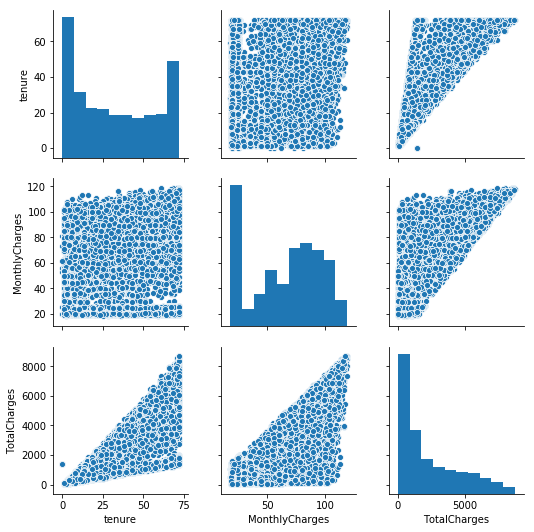

In [189]:
sns.pairplot(X_num)

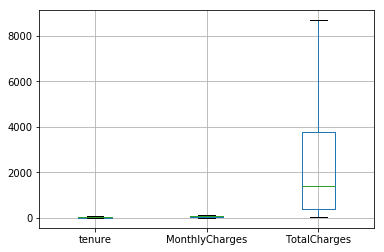

In [190]:
X_num.boxplot()

The distributions of our variables are not Gaussian. You can see a positive skew on the Monthly Charges and peaks at the tails of the tenure distrbution. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1363aaa90>,
      dtype=object)

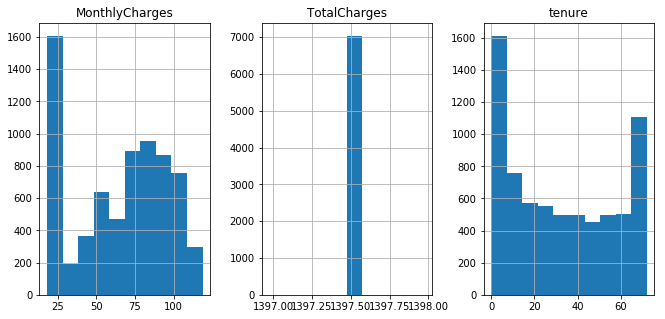

In [67]:
X_num.hist(layout=(1,4), figsize=(15,5))

The below plots show how one binary feature (Online security yes vs no) is represented in the scatterplots of our continuous variables. It's interesting that people with lowest monthly charges are entirely without online security.

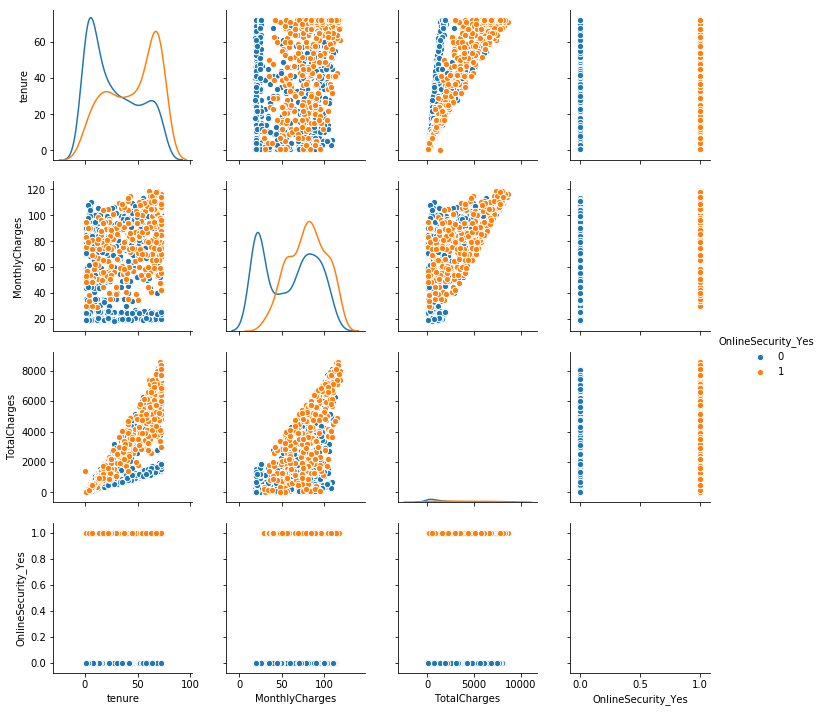

In [192]:
g = sns.PairGrid(pd.concat([X_num, X['OnlineSecurity_Yes']], axis=1).sample(n=1000), hue="OnlineSecurity_Yes")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.map_diag(sns.kdeplot)
g = g.add_legend()

Here we can run the same analysis but with the target outcome distribution overlaid on the scatterplots. Here we can see the density of churners is peaking at lower levels of tenure and higher levels of monthly charges. We also can see that the combination of high monthly charges and low tenure seems to be especially likely to produce churners. 

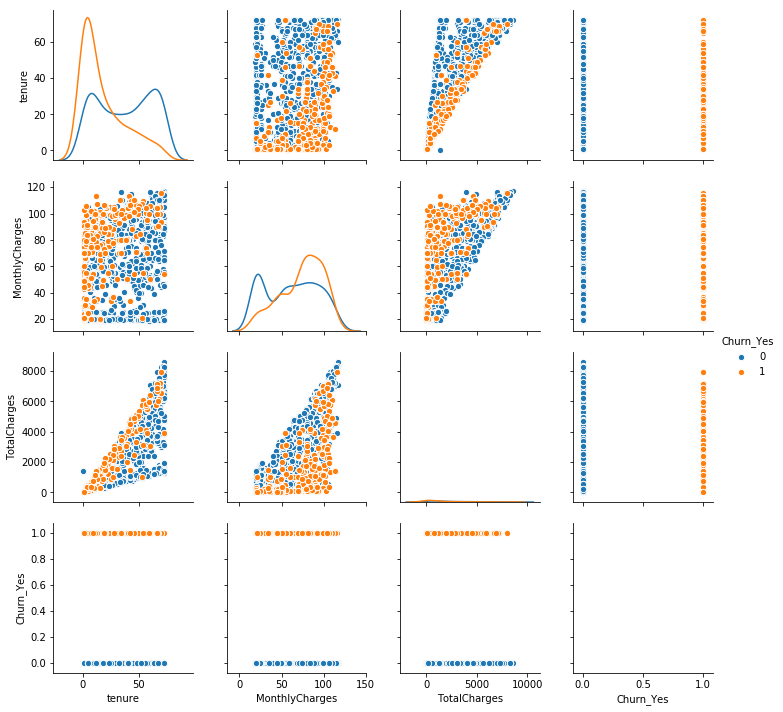

In [193]:
g = sns.PairGrid(pd.concat([X_num, Y], axis=1).sample(n=1000), hue="Churn_Yes")
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.map_diag(sns.kdeplot)
g = g.add_legend()

We can also investigate the distribution of online security and churning in violin plots or with classic bar charts. In the bar chart we can see that people with high levels are tenure are equally likely to have online security, whereas at low levels of tenure customers are much more likely to not have online security. Middle levels of tenure show a preference for no online security, but a weaker effect compared to low levels of tenure. 

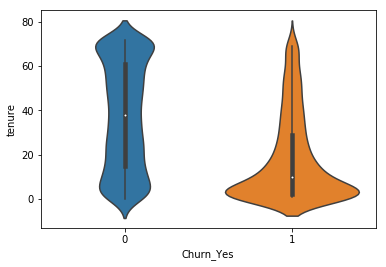

In [194]:
sns.violinplot(x="Churn_Yes", y="tenure", data=pd.concat([X_num, Y], axis=1))

In [195]:
tenure_bins=pd.cut(X["tenure"], bins=[0,20,60,80], labels=['low','medium','high'])

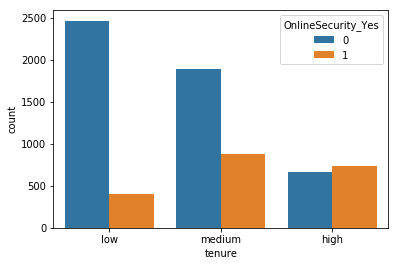

In [197]:
sns.countplot(x=tenure_bins, hue="OnlineSecurity_Yes", data=pd.concat([X_num, X['OnlineSecurity_Yes']], axis=1))

Churning is less likely than non-churning across the board, but the magnitude of this difference between churners and non-churners depends on the level of tenure. There is a linear effect, such that the ratio of churners to non churners is lowest at high levels of tenure, second for medium levels of tenure, and third for low levels of tenure. This will likely be an important predictor for our models. 

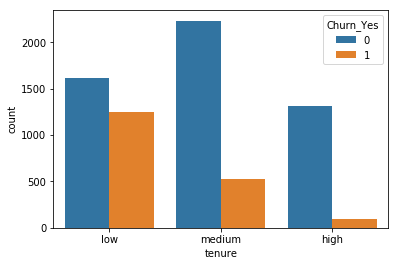

In [198]:
sns.countplot(x=tenure_bins, hue="Churn_Yes", data=pd.concat([X_num, Y], axis=1))

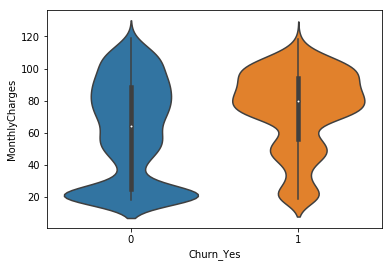

In [199]:
sns.violinplot(x="Churn_Yes", y="MonthlyCharges", data=pd.concat([X_num, Y], axis=1))

We can see here that monthly charges will also be an important predictor. Rate of churning seems to depend on the level of monthly charges, with the ratio of chuners to non churners being low for those with low monthly charges and high for those with high monthly charges. 

In [200]:
MonthlyCharges_bins=pd.cut(X["MonthlyCharges"], bins=[0,35,60,130], labels=['low','medium', 'high'])

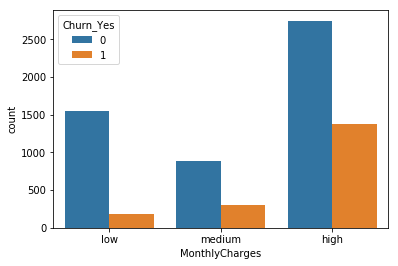

In [132]:
sns.countplot(x=MonthlyCharges_bins, hue="Churn_Yes", data=pd.concat([X_num, Y], axis=1))

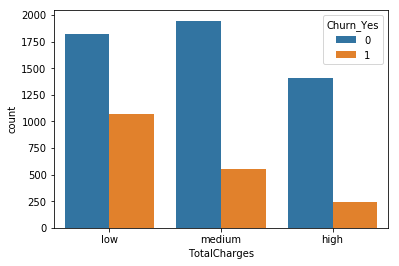

In [201]:
TotalCharges_bins=pd.cut(X["TotalCharges"], bins=[0,1000,4000,10000], labels=['low','medium','high'])
sns.countplot(x=TotalCharges_bins, hue="Churn_Yes", data=pd.concat([X_num, Y], axis=1))

Quantile plots show us how the rate of churning changes across quantiles of tenure or other variables. There is a clear decreasing linear trend of churn rate across the distribution of tenure. As well, there is a non-linear, but mostly increasing trend of churn rate across quantiles of monthly charges. 

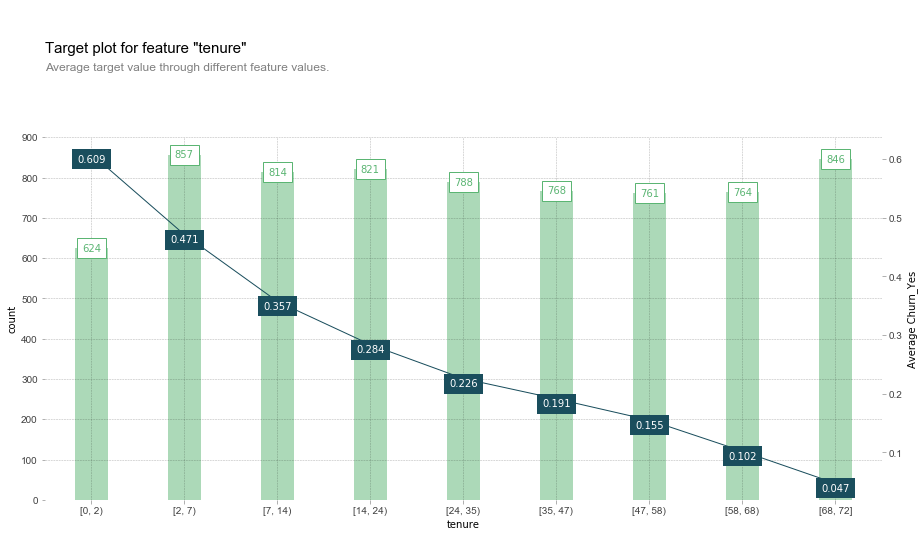

In [68]:
fig, axes, summary_df = info_plots.target_plot(
df=pd.concat([X, Y], axis=1), feature='tenure', feature_name='tenure', target='Churn_Yes')

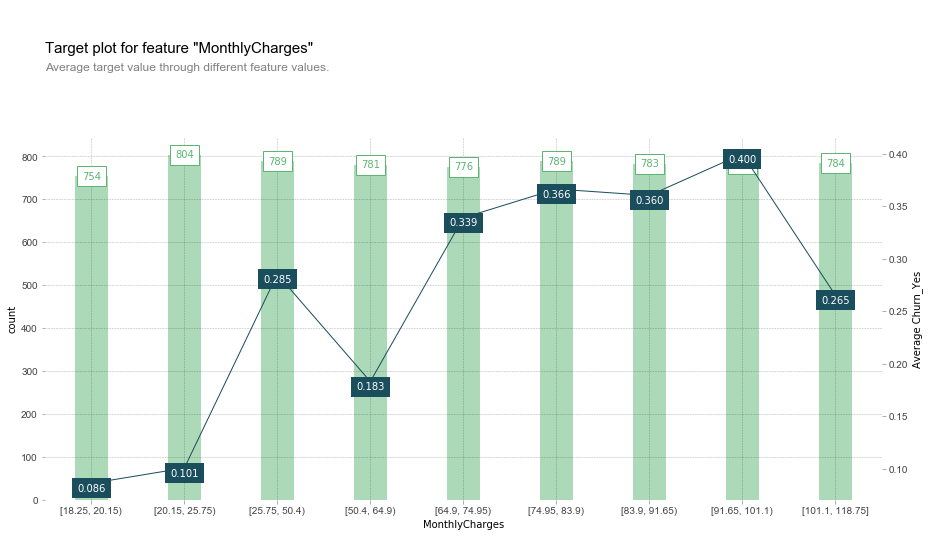

In [203]:
fig, axes, summary_df = info_plots.target_plot(
df=pd.concat([X, Y], axis=1), feature='MonthlyCharges', feature_name='MonthlyCharges', target='Churn_Yes')

Finally, we can view an interaction plot that investigates the churn rate at various level combinations of two separate variables. In the plot below darker colors represent higher churn rate and the size of the dots represents volume at the intersection of the respective quantiles. We can see an interesting interaction pattern, such that churn rate increases as a main effect of monthly charges; the higher the monthly charge the more likely there is to be churning. But this effect is pronounced for customers in the lower half of the tenure distribution. You can see the circles going from light to dark at a steeper incline in this group vs the high tenure half. 

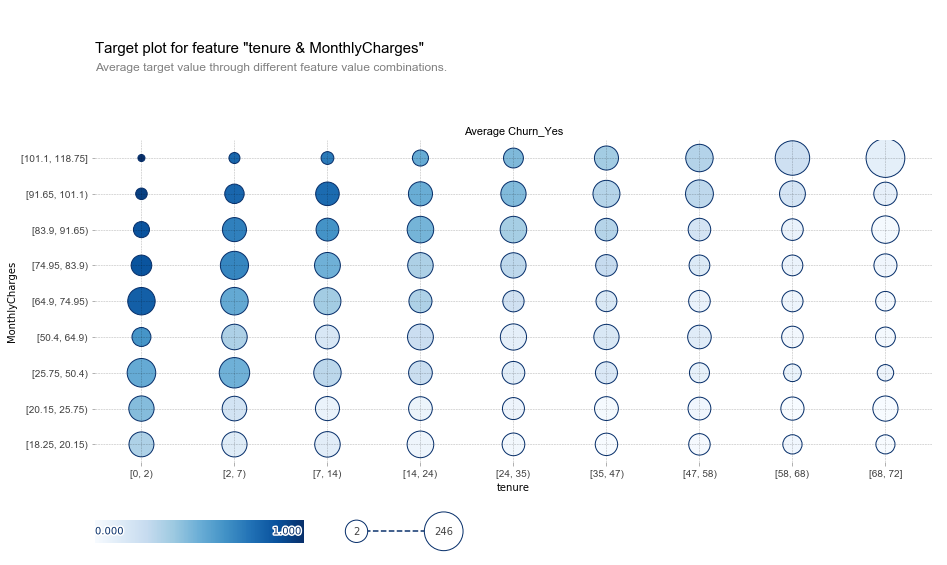

In [204]:
fig, axes, summary_df = info_plots.target_plot_interact(
df=pd.concat([X, Y], axis=1), features=['tenure', 'MonthlyCharges'],
feature_names=['tenure', 'MonthlyCharges'], target='Churn_Yes'
)

We can see the churn rate by categorical features as well. 

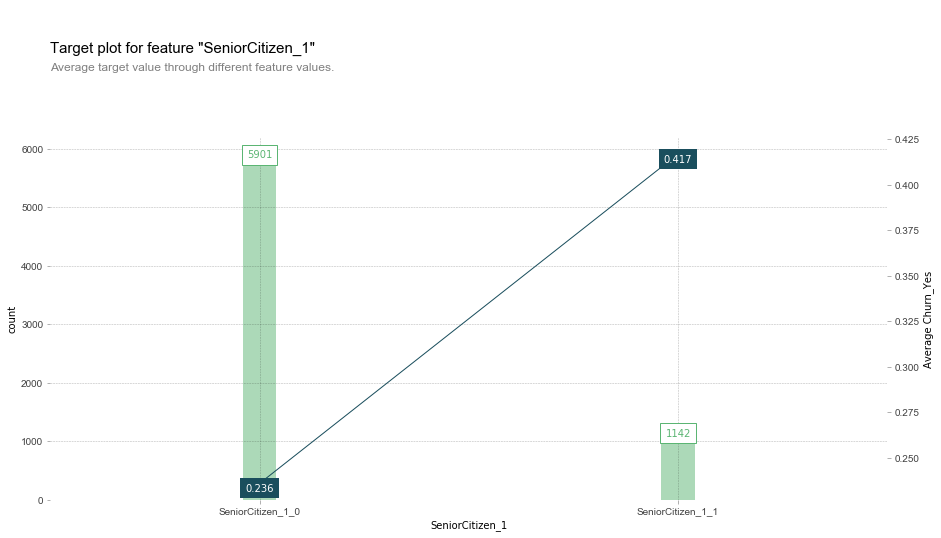

In [206]:
fig, axes, summary_df = info_plots.target_plot(
    df=pd.concat([X, Y], axis=1), feature='SeniorCitizen_1', feature_name='SeniorCitizen_1', target='Churn_Yes'
)

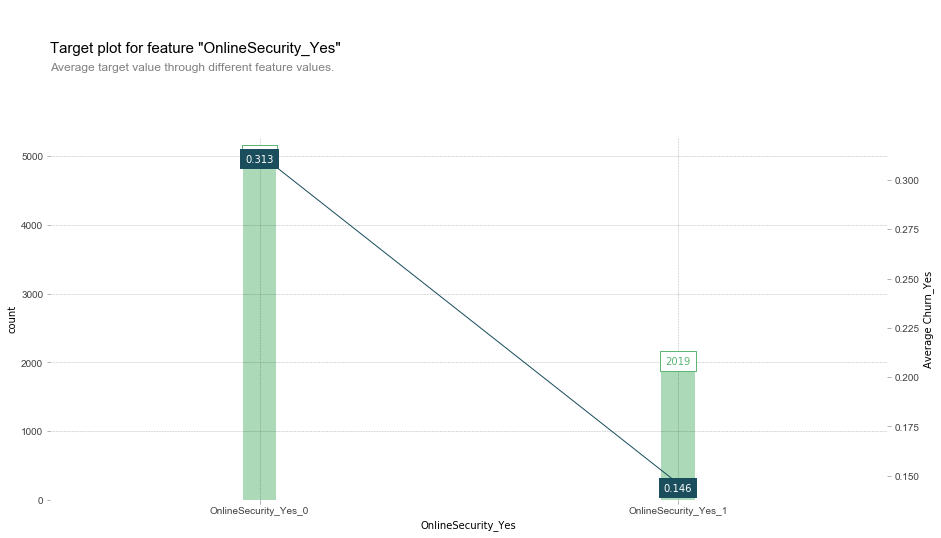

In [71]:
fig, axes, summary_df = info_plots.target_plot(
    df=pd.concat([X, Y], axis=1), feature='OnlineSecurity_Yes', feature_name='OnlineSecurity_Yes', target='Churn_Yes'
)

 ## 5. Machine Learning
 
 Here I will build a supervised machine learning algorithm to predict customer churn. First I'll split the data into train and test sets, retaining the same distribution of churners to non churners across both data sets. Then I'll tune a hyperparameter grid for a Random Forest algorithm. This will include parameters such as the tree depth, the max number of features to consider at each split, the number of trees, etc. Then I will run a process of cross validation to tune the parameters and find the optimal model. 

In [208]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [216]:
y_test.shape

,Churn_Yes
5557,0
2270,1
6930,1
2257,0
898,1
3828,0
2147,0
3149,0
5401,0
2062,0


In [217]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]

# Number of features to consider at every split.
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 50, num = 5)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 16, 27, 38, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [5, 10],
 'n_estimators': [200, 650, 1100, 1550, 2000]}


In [218]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,
                               scoring='accuracy')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.5min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 650, 1100, 1550, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 16, 27, 38, 50, None], 'min_samples_split': [5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [95]:
rf_random.best_params_

{'n_estimators': 650,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 16,
 'bootstrap': True}

In [221]:
rf_random.best_score_

0.8024340770791075

In [222]:
param_grid = rf_random.best_params_
rf_best = RandomForestClassifier(**param_grid)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

We have fit our best model, and here are the importance score for the feature in this model. 

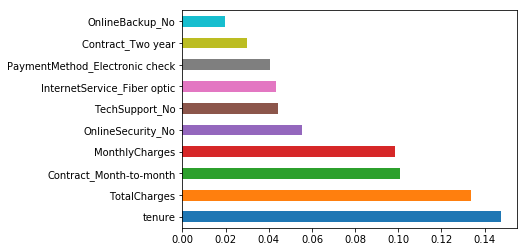

In [223]:
feat_importances = pd.Series(rf_best.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

As expected based on our EDA, tenure, Total, and Monthly charges are all important for the prediction. However, surprisingly, whether the customer was on a month-to-month contract also influenced the outcome.

In [73]:
rf_predictions = rf_best.predict(X_test)

NameError: name 'rf_best' is not defined

In [225]:
rf_predictions

array([1, 0, 1, ..., 0, 0, 0], dtype=uint8)

Here is a confusion matrix and accuracy score of the predictions. We get a 79% accuracy on this model. This beats our baseline (naive) model (73%) of simple guessing the modal outcome each time. Yay machine learning. 

Confusion matrix:
Predicted  False  True  __all__
Actual                         
False        355    98      453
True         140    24      164
__all__      495   122      617


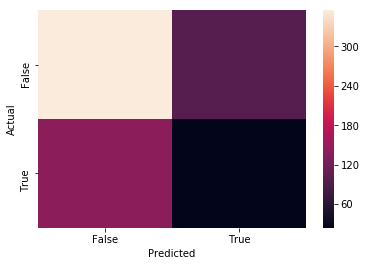

In [226]:
conf_mat = ConfusionMatrix(pd.Series(y_test.Churn_Yes), pd.Series(rf_predictions))
print("Confusion matrix:\n%s" % conf_mat)

conf_mat.plot(backend='seaborn')

In [227]:
print(accuracy_score(y_test, rf_predictions))

0.7974443918599148


In [228]:
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1552
           1       0.66      0.49      0.56       561

   micro avg       0.80      0.80      0.80      2113
   macro avg       0.75      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



In [230]:
y_test.Churn_Yes.value_counts(normalize=True)

0    1552
1     561
Name: Churn_Yes, dtype: int64

In [232]:
pd.Series(rf_predictions).value_counts()

0    1694
1     419
dtype: int64

# Deep Learning

Let's see if we can beat our Random Forest using the Keras package with a Tensorflow backend. We'll build a Artifical Neural Network to model our churn problem. 

In [242]:
model = Sequential()
model.add(Dense(16, input_dim=len(X_train.columns), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=100)
_, accuracy = model.evaluate(X_test, y_test)

Train on 4930 samples, validate on 2113 samples
Epoch 1/150
4930/4930 [==============================] - 1s 209us/step - loss: 2.9134 - acc: 0.7126 - val_loss: 1.6091 - val_acc: 0.7506
Epoch 2/150
4930/4930 [==============================] - 0s 20us/step - loss: 1.8465 - acc: 0.7233 - val_loss: 1.6301 - val_acc: 0.7392
Epoch 3/150
4930/4930 [==============================] - 0s 24us/step - loss: 0.9774 - acc: 0.7286 - val_loss: 1.0484 - val_acc: 0.6171
Epoch 4/150
4930/4930 [==============================] - 0s 24us/step - loss: 0.7224 - acc: 0.7256 - val_loss: 0.7681 - val_acc: 0.7591
Epoch 5/150
4930/4930 [==============================] - 0s 20us/step - loss: 0.6460 - acc: 0.7365 - val_loss: 0.9553 - val_acc: 0.7615
Epoch 6/150
4930/4930 [==============================] - 0s 21us/step - loss: 0.5607 - acc: 0.7471 - val_loss: 0.5227 - val_acc: 0.7113
Epoch 7/150
4930/4930 [==============================] - 0s 20us/step - loss: 1.0109 - acc: 0.7199 - val_loss: 0.8161 - val_acc: 0.7610

4930/4930 [==============================] - 0s 21us/step - loss: 0.4704 - acc: 0.7897 - val_loss: 0.7352 - val_acc: 0.7866
Epoch 120/150
4930/4930 [==============================] - 0s 21us/step - loss: 0.5074 - acc: 0.7907 - val_loss: 0.4223 - val_acc: 0.7913
Epoch 121/150
4930/4930 [==============================] - 0s 22us/step - loss: 0.4393 - acc: 0.7939 - val_loss: 0.4755 - val_acc: 0.7586
Epoch 122/150
4930/4930 [==============================] - 0s 22us/step - loss: 0.4317 - acc: 0.7998 - val_loss: 0.4774 - val_acc: 0.7530
Epoch 123/150
4930/4930 [==============================] - 0s 21us/step - loss: 0.4659 - acc: 0.7945 - val_loss: 0.6447 - val_acc: 0.7875
Epoch 124/150
4930/4930 [==============================] - 0s 19us/step - loss: 0.4782 - acc: 0.7937 - val_loss: 0.4339 - val_acc: 0.8041
Epoch 125/150
4930/4930 [==============================] - 0s 21us/step - loss: 0.4224 - acc: 0.8032 - val_loss: 0.4221 - val_acc: 0.7927
Epoch 126/150
4930/4930 [=======================

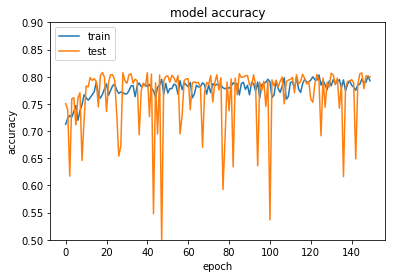

In [243]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
axes = plt.gca()
axes.set_ylim([.5,.90])
plt.show()

As seen, we made a small, but measurable improvement on the previous model. It appears that deep learning can be used successfully to predict customer churn. 

In [126]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)


print(accuracy_score(y_test, y_pred))

0.8064363464268812


In [127]:
print(confusion_matrix(y_test, y_pred))

[[1417  135]
 [ 274  287]]


In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.68      0.51      0.58       561

   micro avg       0.81      0.81      0.81      2113
   macro avg       0.76      0.71      0.73      2113
weighted avg       0.80      0.81      0.80      2113



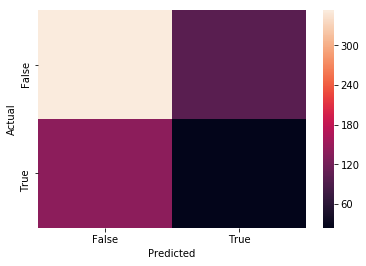

In [129]:
conf_mat.plot(backend='seaborn')

### Dropout

Finally, let's do one more model, this time we'll use a dropout regularization technique to control the variance on our model. This is typically done when there is a high risk of overfitting. We'll see if this technique can help us to improve our predictive accuracy. 

In [276]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
model = Sequential()
model.add(Dense(40, input_dim=X_train.shape[1], activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = "binary_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=100, callbacks=[checkpointer])

Train on 4930 samples, validate on 2113 samples
Epoch 1/300
4930/4930 [==============================] - 3s 552us/step - loss: 10.3183 - acc: 0.3008 - val_loss: 11.0854 - val_acc: 0.2655

Epoch 00001: val_loss improved from inf to 11.08543, saving model to weights.hdf5
Epoch 2/300
4930/4930 [==============================] - 0s 31us/step - loss: 10.1039 - acc: 0.3108 - val_loss: 11.0391 - val_acc: 0.2655

Epoch 00002: val_loss improved from 11.08543 to 11.03914, saving model to weights.hdf5
Epoch 3/300
4930/4930 [==============================] - 0s 30us/step - loss: 10.0351 - acc: 0.3138 - val_loss: 10.9912 - val_acc: 0.2655

Epoch 00003: val_loss improved from 11.03914 to 10.99115, saving model to weights.hdf5
Epoch 4/300
4930/4930 [==============================] - 0s 30us/step - loss: 9.8275 - acc: 0.3241 - val_loss: 10.9112 - val_acc: 0.2655

Epoch 00004: val_loss improved from 10.99115 to 10.91124, saving model to weights.hdf5
Epoch 5/300
4930/4930 [==============================

4930/4930 [==============================] - 0s 44us/step - loss: 4.6371 - acc: 0.5994 - val_loss: 2.9751 - val_acc: 0.7345

Epoch 00084: val_loss did not improve from 1.29770
Epoch 85/300
4930/4930 [==============================] - 0s 45us/step - loss: 4.7523 - acc: 0.5980 - val_loss: 2.9756 - val_acc: 0.7345

Epoch 00085: val_loss did not improve from 1.29770
Epoch 86/300
4930/4930 [==============================] - 0s 42us/step - loss: 4.8571 - acc: 0.5892 - val_loss: 2.9762 - val_acc: 0.7345

Epoch 00086: val_loss did not improve from 1.29770
Epoch 87/300
4930/4930 [==============================] - 0s 40us/step - loss: 4.6280 - acc: 0.6030 - val_loss: 2.9753 - val_acc: 0.7345

Epoch 00087: val_loss did not improve from 1.29770
Epoch 88/300
4930/4930 [==============================] - 0s 43us/step - loss: 4.6206 - acc: 0.6075 - val_loss: 2.9732 - val_acc: 0.7345

Epoch 00088: val_loss did not improve from 1.29770
Epoch 89/300
4930/4930 [==============================] - 0s 42us/st

4930/4930 [==============================] - 0s 36us/step - loss: 3.4190 - acc: 0.6602 - val_loss: 2.5255 - val_acc: 0.7539

Epoch 00170: val_loss did not improve from 1.29770
Epoch 171/300
4930/4930 [==============================] - 0s 37us/step - loss: 3.3312 - acc: 0.6732 - val_loss: 2.5211 - val_acc: 0.7539

Epoch 00171: val_loss did not improve from 1.29770
Epoch 172/300
4930/4930 [==============================] - 0s 36us/step - loss: 3.3204 - acc: 0.6706 - val_loss: 2.5145 - val_acc: 0.7539

Epoch 00172: val_loss did not improve from 1.29770
Epoch 173/300
4930/4930 [==============================] - 0s 36us/step - loss: 3.3730 - acc: 0.6621 - val_loss: 2.5103 - val_acc: 0.7539

Epoch 00173: val_loss did not improve from 1.29770
Epoch 174/300
4930/4930 [==============================] - 0s 35us/step - loss: 3.4242 - acc: 0.6637 - val_loss: 2.5051 - val_acc: 0.7544

Epoch 00174: val_loss did not improve from 1.29770
Epoch 175/300
4930/4930 [==============================] - 0s 36

4930/4930 [==============================] - 0s 30us/step - loss: 2.7802 - acc: 0.6870 - val_loss: 1.5238 - val_acc: 0.7530

Epoch 00256: val_loss did not improve from 1.29770
Epoch 257/300
4930/4930 [==============================] - 0s 33us/step - loss: 2.7559 - acc: 0.6763 - val_loss: 1.4762 - val_acc: 0.7530

Epoch 00257: val_loss did not improve from 1.29770
Epoch 258/300
4930/4930 [==============================] - 0s 32us/step - loss: 2.7693 - acc: 0.6854 - val_loss: 1.4799 - val_acc: 0.7530

Epoch 00258: val_loss did not improve from 1.29770
Epoch 259/300
4930/4930 [==============================] - 0s 29us/step - loss: 2.6824 - acc: 0.6872 - val_loss: 1.4220 - val_acc: 0.7525

Epoch 00259: val_loss did not improve from 1.29770
Epoch 260/300
4930/4930 [==============================] - 0s 31us/step - loss: 2.5907 - acc: 0.6923 - val_loss: 1.3780 - val_acc: 0.7525

Epoch 00260: val_loss did not improve from 1.29770
Epoch 261/300
4930/4930 [==============================] - 0s 37

2113/2113 [==============================] - 0s 27us/step


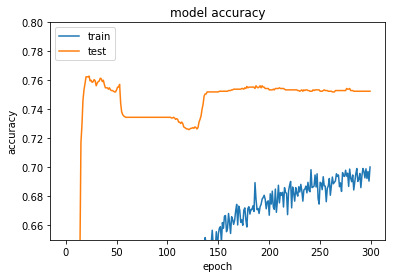

In [278]:
_, accuracy = model.evaluate(X_test, y_test)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
axes = plt.gca()
axes.set_ylim([.65,.80])
plt.show()

It appears that dropout actually hurt performance in this case. The Random Forest and the unregularized ANN were both better than the regularized ANN. 

In [248]:
predicted = model.predict(X_test)

0.7723615712257453
[[1535   17]
 [ 464   97]]
              precision    recall  f1-score   support

           0       0.77      0.99      0.86      1552
           1       0.85      0.17      0.29       561

   micro avg       0.77      0.77      0.77      2113
   macro avg       0.81      0.58      0.58      2113
weighted avg       0.79      0.77      0.71      2113



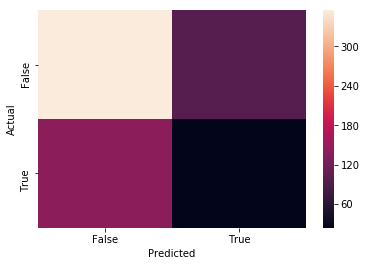

In [241]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)


print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

conf_mat.plot(backend='seaborn')

## Feature Importance Analysis

Recent strides in machine learning have made it more possible to investigate how features play a role in predicting. With partial dependence plots, we can investigate how the predicted outcome changes at various points in a feature's distribution. For example, below we can see that as customers go from not senior citizen to senior citizen their probability of churning increases. As well, we can see that the probability of churning increases with monthly charges. Finally, it appears that our model will predict a lower probability of churning with increases in tenure, and this relationship though non-linear is monotonically decreasing. 

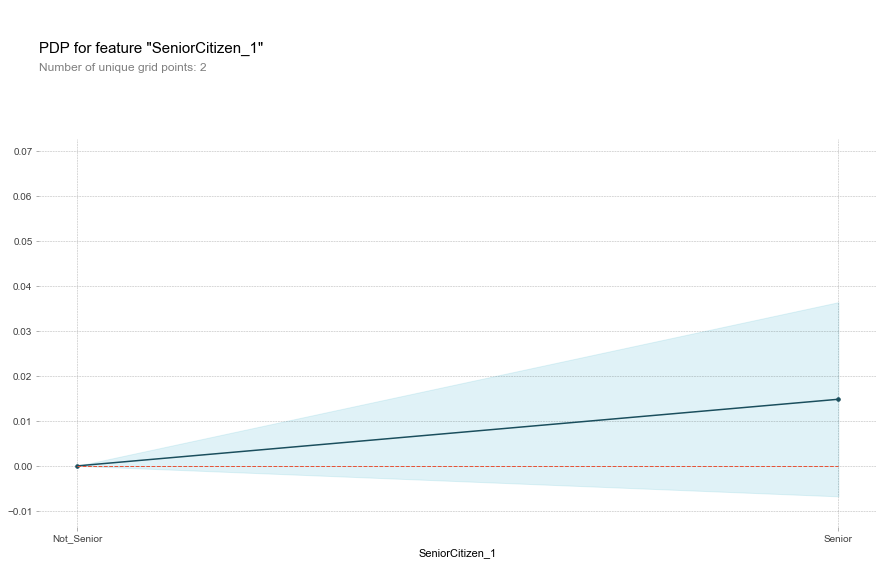

In [142]:
pdp_senior = pdp.pdp_isolate(
    model=rf_best, dataset=pd.concat([X, Y], axis=1), model_features=X.columns, feature='SeniorCitizen_1'
)
fig, axes = pdp.pdp_plot(pdp_senior, 'SeniorCitizen_1')
_ = axes['pdp_ax'].set_xticklabels(['Not_Senior', 'Senior'])

In [140]:
X.head()

,tenure,MonthlyCharges,TotalCharges,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,PaperlessBilling_Yes
0,1,29.85,29.85,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
1,34,56.95,1889.50,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0
2,2,53.85,108.15,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,1
3,45,42.30,1840.75,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0
4,2,70.70,151.65,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1


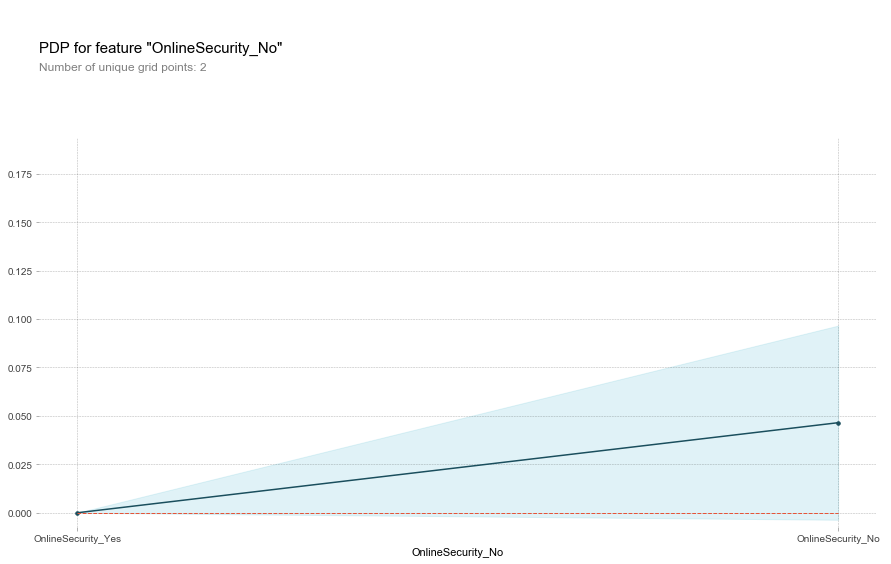

In [143]:
pdp_sec = pdp.pdp_isolate(
    model=rf_best, dataset=pd.concat([X, Y], axis=1), model_features=X.columns, feature='OnlineSecurity_No'
)
# default
fig, axes = pdp.pdp_plot(pdp_sec, 'OnlineSecurity_No')
_ = axes['pdp_ax'].set_xticklabels(['OnlineSecurity_Yes', 'OnlineSecurity_No'])

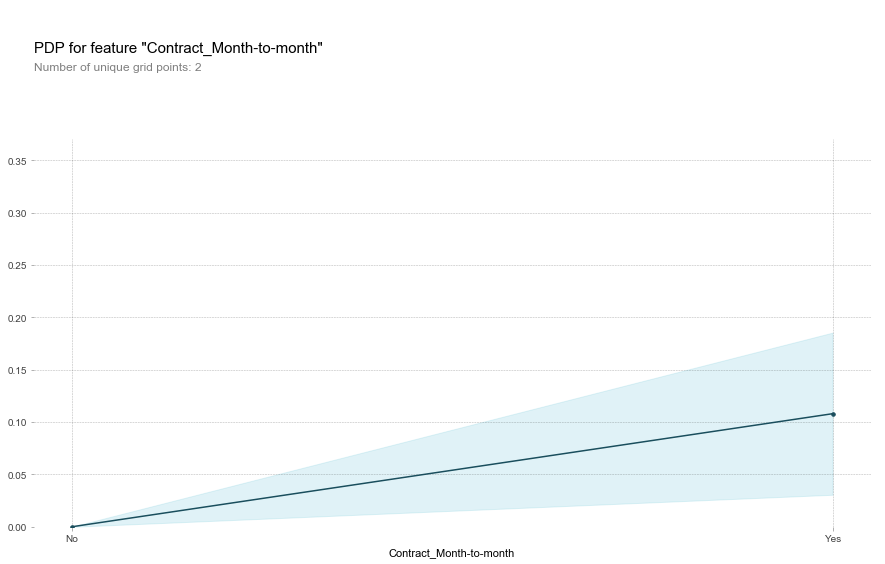

In [146]:
pdp_cont = pdp.pdp_isolate(
    model=rf_best, dataset=pd.concat([X, Y], axis=1), model_features=X.columns, feature='Contract_Month-to-month'
)
# default
fig, axes = pdp.pdp_plot(pdp_cont, 'Contract_Month-to-month')
_ = axes['pdp_ax'].set_xticklabels(['No', 'Yes'])


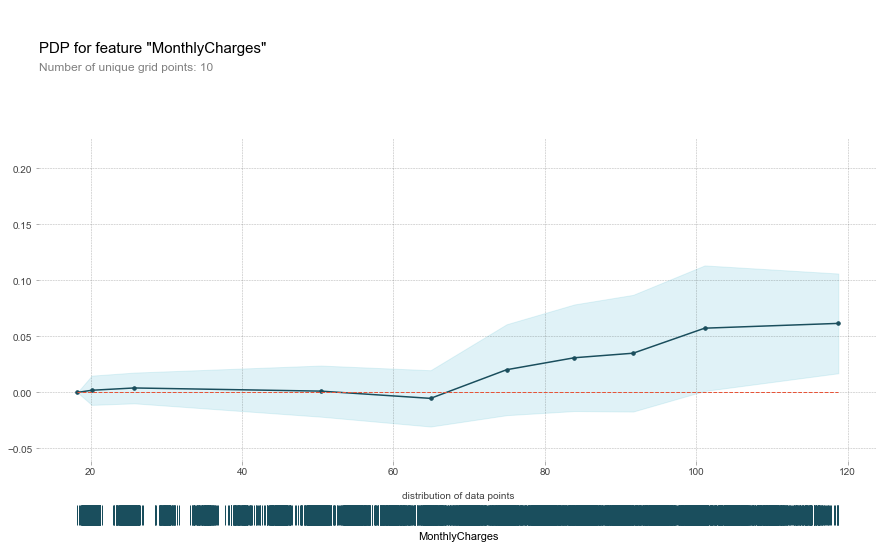

In [145]:
# We can see as monthly charges go up there is no effect on churn prediction until about 65 dollars or above, at which point it goes up. Once a customer's monthly charges exceed 65 dollars, we should be increasingly cautious of customers churning with higher monthly charges. 

pdp_monthly = pdp.pdp_isolate(
    model=rf_best, dataset=pd.concat([X, Y], axis=1), model_features=X.columns, feature='MonthlyCharges'
)
# default
fig, axes = pdp.pdp_plot(pdp_monthly, 'MonthlyCharges', plot_pts_dist=True)

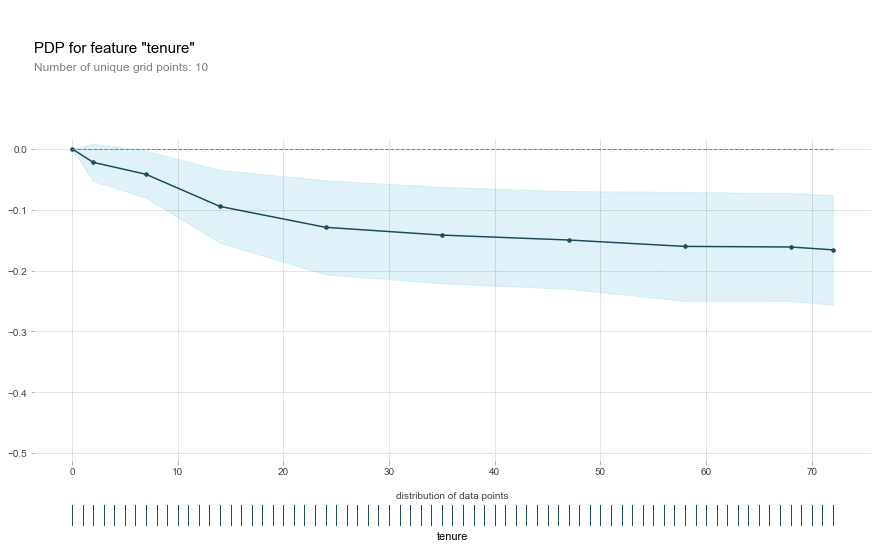

In [144]:
pdp_tenure = pdp.pdp_isolate(
    model=rf_best, dataset=pd.concat([X, Y], axis=1), model_features=X.columns, feature='tenure'
)
# default
fig, axes = pdp.pdp_plot(pdp_tenure, 'tenure', plot_pts_dist=True)

## Conclusions

This concludes our analysis on Telco customers who churned vs didn't churn. I have demonstrated how the data cleaning process works, how a thorough exploratory data analysis can be used to uncover interesting insights about the data, and how supervised machine learning and deep learning methods can be used to predict customer churn better than baseline models. 

Investigating the behavior of customer churn models, such as through partial dependency plots, can also tell us exactly how features are contributing to the predictions. 

I learned that customer charges and their tenure as a customer play an important role in predicting their churn. As well, being a senior citizen or on a month-to-month contract also seem to correlate with changes in churn rate. 

Overall, more broadly, similar techniques and statistical learning models can be applied to any attrition problem across industry and government organizations. 